In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from copy import deepcopy

# Function used

In [26]:
def cfm(x, y, model):
    flat = model.convolution(x)
    yhat = model.feedForwardTest(flat)
    pred = tf.argmax(yhat, axis = 1)
    true = tf.argmax(y, axis = 1)
    cfm = confusion_matrix(y_true= true, y_pred= pred)
    return(cfm)

    
def each_class(x_trina, y_train, x_test, y_test, model):
    cfm1 = cfm(x_trina, y_train, model)
    cfm2 = cfm(x_test, y_test, model)
    
    each_class = {
        "good": [cfm1[0][0]/cfm1[0].sum(), cfm2[0][0]/cfm2[0].sum()],
        "none": [cfm1[1][1]/cfm1[1].sum(), cfm2[1][1]/cfm2[1].sum()],
        "bad": [cfm1[2][2]/cfm1[2].sum(), cfm2[2][2]/cfm2[2].sum()]}
    result = pd.DataFrame.from_dict(each_class, orient='index', columns= ["Train Acc", "Test Acc"])
    print(result)

# Data process

In [ ]:
def data_process(data):
    L = []
    for filename, xmin, ymin, xmax, ymax \
        in zip(data["filename"],data["xmin"], data["ymin"], data["xmax"], data["ymax"]):
        path = os.path.join("problem2-CNN/images/" + filename)
        img = Image.open(path).convert(mode = "RGB").crop((xmin, ymin, xmax, ymax))
        img = img.resize((80,80))
        data_np = np.array(img).astype(np.float32) / 225.
        L.append(data_np)
    return L

def onehot(y):
    if y == "good":
        return np.array([1,0,0])
    elif y == "bad":
        return np.array([0,0,1])
    else:
        return np.array([0,1,0])
    
X_train = data_process(train)
X_test = data_process(test)

y_train_label = list(train["label"])
y_test_label = list(test["label"])

In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [5]:
X_train.shape

(3528, 80, 80, 3)

In [45]:
class CNN:
    def __init__(self, fliter_num, fliter_size, img_size, units, strides = 1, k = 2):
        random_Normal = tf.initializers.RandomNormal()
        
        # convolution
        self.fliter_num = fliter_num # fliter [32, 64]
        self.fliter_size = fliter_size # 5x5, 6x6
        self.conv_num = len(fliter_num) # 2
        self.channel = [3] + [fliter_num[i] for i in range(len(fliter_num))]
        self.strides = strides
        self.img_size = img_size # 80 means 80x80
        
        # max pooling
        self.k = k
        
        # fully connected
        self.units = [int((img_size / 2**len(fliter_num))**2*fliter_num[-1])] + units
        self.flayers = len(units) + 1

        # initialize parameters of convolution
        self.cweights = [
            tf.Variable(random_Normal(
                [self.fliter_size[i][0], self.fliter_size[i][0], self.channel[i], self.fliter_num[i]]
            ),trainable = True) for i in range(self.conv_num)]
        
        self.cbiases = [
            tf.Variable(tf.zeros([self.channel[i + 1]]) ,trainable = True) for i in range(self.conv_num)]
        
        # initialize parameters of fully connected
        self.fweights = [
            tf.Variable(random_Normal(
                [x, y]
            ) ,trainable = True) for x, y in zip(self.units[:-1], self.units[1:])]
        self.fbiases = [
            tf.Variable(random_Normal(
                [x] 
            ) ,trainable = True) for x in self.units[1:]]

        # save information
        self.training_acc = []
        self.testing_acc = []
        self.training_loss = []
        
#=====main start=====        
    def train(self, X_train, y_train, epochs, m, X_test, y_test, dropout = True, balance = True):
        self.epochs = epochs
        self.m = m
        self.dropout = dropout
        self.balance = balance
        optimizer = tf.optimizers.Adam(learning_rate = 0.001)
        
        # train & update weights
        for epoch in range(epochs):
            ind = np.random.permutation(range(len(X_train)))
            for i in range(0, len(X_train), m):
                mini_batch_ind = ind[i : i+m]
                X_mini_batch = X_train[mini_batch_ind]
                y_mini_batch = y_train[mini_batch_ind]
                
                with tf.GradientTape() as tape:
                    flatten = self.convolution(X_mini_batch)
                    prob = self.feedForwardTest(flatten)
                    loss = self.crossEntropy(y_mini_batch, prob)
                parameters = self.cweights + self.cbiases + self.fweights + self.fbiases
                grades = tape.gradient(loss, parameters)
                optimizer.apply_gradients(zip(grades, parameters))
                
            # training data info
            flat_train = self.convolution(X_train)
            yhat_train = self.feedForwardTest(flat_train)
            loss = self.crossEntropy(y_train, yhat_train)
            acc_train = self.countAcc(y_train, yhat_train)
            
            self.training_acc.append(acc_train)
            self.training_loss.append(loss)
            
            # testing data info
            flat_test = self.convolution(X_test)
            yhat_test = self.feedForward(flat_test)
            acc_test = self.countAcc(y_test, yhat_test)
            
            self.testing_acc.append(acc_test)
            
            print("+++Epoch+++ %d / %d" %(epoch, epochs), end = '\r')
            if (epoch+1) % 10 == 0:
                print("Epoch: %d, Training Accuracy: %f, Training Loss: %f, Testing Accuracy: %f"
                     %(epoch+1, self.training_acc[-1], self.training_loss[-1], self.testing_acc[-1]))
#=====main end===== 


#=====convolution start=====
    def convolution(self, x):
        xs = [x]
        for w, b in zip(self.cweights, self.cbiases):
            conv_out = self.conv(xs[-1], w, b)
            xs.append(self.maxPool(conv_out)) 
            # after convolution loop, xs[-1] will be the input of full connected
        input_full = tf.reshape(xs[-1], [-1, self.units[0]])
        return input_full
    
    def conv(self, x, w, b):
        x = tf.nn.conv2d(
            x, w, strides = [1, self.strides, self.strides, 1], 
            padding = "SAME")
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)
    
    def maxPool(self, x):
        return tf.nn.max_pool(
            x, ksize = [1, self.k, self.k, 1], 
            strides = [1, self.k, self.k, 1], padding = "SAME")
#=====convolution end=====

#=====full connected function start=====
    def feedForward(self, x):
        for w, b in zip(self.fweights, self.fbiases):
            z = tf.add(tf.matmul(x, w), b)
            x = tf.nn.relu(z)
            if self.dropout:
                x = tf.nn.dropout(x, rate = 0.5)
        return tf.nn.softmax(z)
#=====full connected function end=====
    def crossEntropy(self, y_true, y_pred):
        if self.balance:
            class_weights = tf.constant([[1/3129, 1/126, 1/667]])
            weighted = tf.reduce_sum(class_weights * y_true, axis = 1)
            y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
            #unweighted_loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
            unweighted_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred))
            weighted_loss = unweighted_loss * weighted
            return tf.reduce_mean(weighted_loss)
        else:
            y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
            return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

    def countAcc(self, y_true, y_pred):
        acc = tf.equal(tf.argmax(y_pred, axis = 1), tf.argmax(y_true, axis = 1))
        return tf.reduce_mean(tf.cast(acc, tf.float32), axis=0)
    
    def feedForwardTest(self, x):
        for w, b in zip(self.fweights, self.fbiases):
            z = tf.add(tf.matmul(x, w), b)
            x = tf.nn.relu(z)
        return tf.nn.softmax(z)

In [31]:
x3 = CNN(fliter_num = [32, 32], fliter_size = ([[3,3], [3,3]]),
         img_size = 80, k = 2,units = [1024, 512 ,3])
x3.train(X_train, y_train,X_test = X_test, y_test = y_test,
         epochs=50, m=100, dropout = False, balance = False)

Epoch: 10, Training Accuracy: 0.992914, Training Loss: 79.369621, Testing Accuracy: 0.913706
Epoch: 20, Training Accuracy: 1.000000, Training Loss: 4.482910, Testing Accuracy: 0.923858
Epoch: 30, Training Accuracy: 1.000000, Training Loss: 0.090356, Testing Accuracy: 0.926396
Epoch: 40, Training Accuracy: 1.000000, Training Loss: 0.033668, Testing Accuracy: 0.928934
Epoch: 50, Training Accuracy: 1.000000, Training Loss: 0.015106, Testing Accuracy: 0.928934


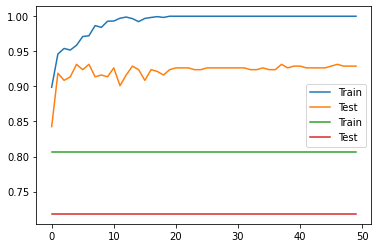

      Train Acc  Test Acc
good        1.0  0.971731
none        1.0  0.363636
bad         1.0  0.932584
      good  none  bad
good   275     3    5
none     7     8    7
bad      5     1   83


In [44]:
plt.plot(x3.training_acc, label = "Train")
plt.plot(x3.testing_acc, label = "Test")
plt.plot(x9.training_acc, label = "Train")
plt.plot(x9.testing_acc, label = "Test")
plt.legend()
plt.show()

each_class(X_train, y_train, X_test, y_test, x3)

print(pd.DataFrame(cfm(X_test, y_test, x3),
            index = ["good", "none", "bad"],
            columns = ["good", "none", "bad"]))

In [34]:
x9 = CNN(fliter_num = [32, 32], fliter_size = ([[9,9], [9,9]]),
         img_size = 80, k = 2,units = [1024, 512 ,3])
x9.train(X_train, y_train,X_test = X_test, y_test = y_test,
         epochs=50, m=100, dropout = False, balance = False)

Epoch: 10, Training Accuracy: 0.806689, Training Loss: 14133.267578, Testing Accuracy: 0.718274
Epoch: 20, Training Accuracy: 0.806689, Training Loss: 14133.267578, Testing Accuracy: 0.718274
Epoch: 30, Training Accuracy: 0.806689, Training Loss: 14133.267578, Testing Accuracy: 0.718274
Epoch: 40, Training Accuracy: 0.806689, Training Loss: 14133.267578, Testing Accuracy: 0.718274
Epoch: 50, Training Accuracy: 0.806689, Training Loss: 14133.267578, Testing Accuracy: 0.718274


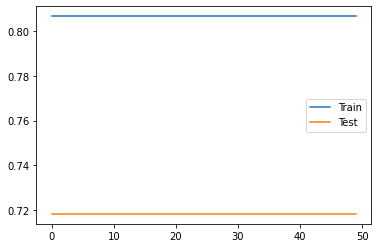

      Train Acc  Test Acc
good        1.0       1.0
none        0.0       0.0
bad         0.0       0.0


In [35]:
plt.plot(x9.training_acc, label = "Train")
plt.plot(x9.testing_acc, label = "Test")
plt.legend()
plt.show()

each_class(X_train, y_train, X_test, y_test, x9)

In [46]:
np.random.seed(1)
drop_true = CNN(fliter_num = [32, 32], fliter_size = ([[3,3], [3,3]]),
         img_size = 80, k = 2,units = [1024, 512 ,3])
drop_true.train(X_train, y_train,X_test = X_test, y_test = y_test,
         epochs=50, m=100, dropout = True, balance = False)

Epoch: 10, Training Accuracy: 0.981293, Training Loss: 163.489548, Testing Accuracy: 0.890863
Epoch: 20, Training Accuracy: 0.999433, Training Loss: 9.390347, Testing Accuracy: 0.939086
Epoch: 30, Training Accuracy: 0.998299, Training Loss: 13.073003, Testing Accuracy: 0.931472
Epoch: 40, Training Accuracy: 1.000000, Training Loss: 0.097325, Testing Accuracy: 0.944162
Epoch: 50, Training Accuracy: 1.000000, Training Loss: 0.022542, Testing Accuracy: 0.928934


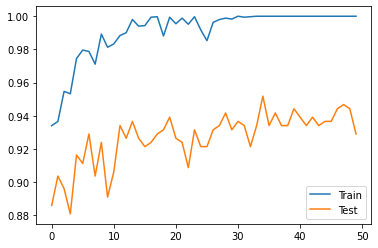

      Train Acc  Test Acc
good        1.0  0.975265
none        1.0  0.454545
bad         1.0  0.955056


In [51]:
plt.plot(drop_true.training_acc, label = "Train")
plt.plot(drop_true.testing_acc, label = "Test")
plt.legend()
plt.show()

each_class(X_train, y_train, X_test, y_test, drop_true)

In [48]:
balance_true = CNN(fliter_num = [32, 32], fliter_size = ([[3,3], [3,3]]),
         img_size = 80, k = 2,units = [1024, 512 ,3])
balance_true.train(X_train, y_train,X_test = X_test, y_test = y_test,
         epochs=50, m=100, dropout = False, balance = True)

Epoch: 10, Training Accuracy: 0.986395, Training Loss: 0.096674, Testing Accuracy: 0.911168
Epoch: 20, Training Accuracy: 0.994048, Training Loss: 0.048569, Testing Accuracy: 0.911168
Epoch: 30, Training Accuracy: 1.000000, Training Loss: 0.000762, Testing Accuracy: 0.934010
Epoch: 40, Training Accuracy: 1.000000, Training Loss: 0.000058, Testing Accuracy: 0.934010
Epoch: 50, Training Accuracy: 1.000000, Training Loss: 0.000030, Testing Accuracy: 0.934010


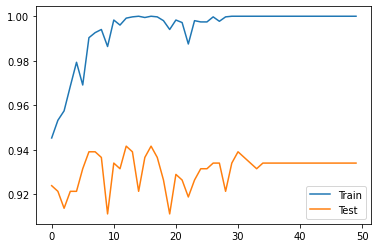

      Train Acc  Test Acc
good        1.0  0.964664
none        1.0  0.454545
bad         1.0  0.955056


In [50]:
plt.plot(balance_true.training_acc, label = "Train")
plt.plot(balance_true.testing_acc, label = "Test")
plt.legend()
plt.show()

each_class(X_train, y_train, X_test, y_test, balance_true)

In [52]:
drop_balance_true = CNN(fliter_num = [32, 32], fliter_size = ([[3,3], [3,3]]),
         img_size = 80, k = 2,units = [1024, 512 ,3])
drop_balance_true.train(X_train, y_train,X_test = X_test, y_test = y_test,
         epochs=50, m=100, dropout = True, balance = True)

Epoch: 10, Training Accuracy: 0.989796, Training Loss: 0.090195, Testing Accuracy: 0.926396
Epoch: 20, Training Accuracy: 1.000000, Training Loss: 0.002168, Testing Accuracy: 0.923858
Epoch: 30, Training Accuracy: 1.000000, Training Loss: 0.000099, Testing Accuracy: 0.934010
Epoch: 40, Training Accuracy: 1.000000, Training Loss: 0.000042, Testing Accuracy: 0.939086
Epoch: 50, Training Accuracy: 1.000000, Training Loss: 0.000022, Testing Accuracy: 0.916244


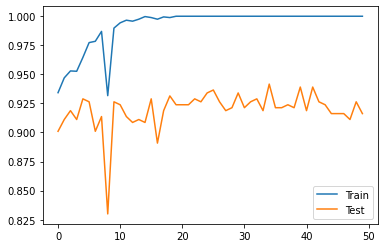

      Train Acc  Test Acc
good        1.0  0.971731
none        1.0  0.454545
bad         1.0  0.943820


In [53]:
plt.plot(drop_balance_true.training_acc, label = "Train")
plt.plot(drop_balance_true.testing_acc, label = "Test")
plt.legend()
plt.show()

each_class(X_train, y_train, X_test, y_test, drop_balance_true)